# Library

In [1]:
import os
from os import listdir
from os.path import isfile, join
import json

import numpy as np

import krippendorff

from sklearn.metrics import f1_score, precision_score,recall_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

## BRAT File Reader

In [2]:
def read_file_brat(file_name_ann, dict_file = dict()):

    #file_name_ann is ann file in brat folder
    #dict_file optional. Can increment a dictionary if pass as parameter.
    #if not it will create from scratch

    #txt file name
    #need to be in same folder
    file_name_txt = file_name_ann[:-3] + 'txt'

    if os.path.isfile(file_name_ann) and os.path.isfile(file_name_txt):

        #annotated file
        f = open(file_name_ann)
        annot_file_list = f.readlines()
        annot_file_list = [x.replace('\n','') for x in annot_file_list]

        #raw file
        f = open(file_name_txt)
        raw_file_list = f.readlines()
        raw_file_list = [x.replace('\n','') for x in raw_file_list]

        #fill all IDs from raw text
        for x in raw_file_list:
            dict_file[x.split('     ')[0]] = ""

        #put labels on ids
        for x in annot_file_list:
            slices = x.split('\t')
            if slices[0][0]=='T':
                dict_file[slices[2]] = slices[1].split(' ')[0]

        
        #return final dict
        return dict_file

    else:
        print("Check de files. Maybe they dont exist in folder.")
        return dict()

## Dictionary to JSON Converter

In [3]:
import json

# dict = the dictionary to convert, file_path = the path where the converted file will be saved
def dict_to_json(dict_file, file_path):

    try:
        with open(file_path, 'w') as json_file:
            json.dump(dict_file, json_file, indent=4)
        print(f"JSON file has been created at {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Read Files

In [4]:
# empty dictionary
import os 

zuil_dict = {}

zuil_dict = read_file_brat('Z/EST_R07_Z.ann', zuil_dict)
zuil_dict = read_file_brat('Z/EST_R10_Z.ann', zuil_dict)
zuil_dict = read_file_brat('Z/RAC_R07_Z.ann', zuil_dict)
zuil_dict = read_file_brat('Z/VAC_R02_Z.ann', zuil_dict)
zuil_dict = read_file_brat('Z/VES_R05_Z.ann', zuil_dict)

dict_to_json(zuil_dict, 'Z/zuil_dict.json')

luiza_dict = {}

luiza_dict = read_file_brat('L/EST_R07_L.ann', luiza_dict)
luiza_dict = read_file_brat('L/EST_R10_L.ann', luiza_dict)
luiza_dict = read_file_brat('L/RAC_R07_L.ann', luiza_dict)
luiza_dict = read_file_brat('L/VAC_R02_L.ann', luiza_dict)
luiza_dict = read_file_brat('L/VES_R05_L.ann', luiza_dict)

dict_to_json(luiza_dict, 'L/luiza_dict.json')


JSON file has been created at Z/zuil_dict.json
JSON file has been created at L/luiza_dict.json


## Methodology #1
Processing values as 0 if its null and 1 if its '0' or '1'

In [5]:
def process_json_values1(json_file, file_path):

    with open(json_file, 'r') as file:
        input_json = json.load(file)

    for key, value in input_json.items():
        # if value is '' update to '0', if its 0 or 1, update to '1'
        if value == '' or value == '0' or value == '1':
            input_json[key] = '0' if value == '' else '1'

    with open(file_path, 'w') as file:
        json.dump(input_json, file)

## Methodology #2
Processing values as 0 if its null, 1 if its '0', and 2 if its '1'

In [6]:
def process_json_values2(json_file, file_path):

    with open(json_file, 'r') as file:
        input_json = json.load(file)

    for key, value in input_json.items():
        # if value is '' update to '0', if its 0 update to '1', if its 1 update to '2'
        if value == '':
            input_json[key] = '0'
        elif value == '0':
            input_json[key] = '1'
        elif value == '1':
            input_json[key] = '2'

    with open(file_path, 'w') as file:
        json.dump(input_json, file)

In [8]:
process_json_values1('Z/zuil_dict.json', 'Z/zuil_dict_m1.json')
process_json_values2('Z/zuil_dict.json', 'Z/zuil_dict_m2.json')

process_json_values1('L/luiza_dict.json', 'L/luiza_dict_m1.json')
process_json_values2('L/luiza_dict.json', 'L/luiza_dict_m2.json')

## Methodology #1

In [24]:
import json
import numpy as np
from krippendorff import alpha

# load JSON files
with open('L/luiza_dict_m1.json') as file:
    luiza_annotations = json.load(file)
with open('Z/zuil_dict_m1.json') as file:
    zuil_annotations = json.load(file)

# assuming both annotators annotated the same items and the items are in the same order
# extract annotations into a list of lists format for Krippendorff's alpha
items = sorted(luiza_annotations.keys())  # in order
data_matrix_1 = [[], []]  # Preparing a 2-row matrix for two annotators

for item in items:
    luiza = luiza_annotations.get(item, None)
    zuil = zuil_annotations.get(item, None)
    
    # append annotations to the matrix if both annotators have annotated the item
    if luiza is not None and zuil is not None:
        data_matrix_1[0].append(int(luiza))
        data_matrix_1[1].append(int(zuil))

# convert the lists into a numpy array for alpha calculation
data_matrix_1 = np.array(data_matrix_1)
# print(data_matrix)
# print(data_matrix.shape)

# Krippendorff #1

In [25]:
alpha_scalar = alpha(reliability_data=data_matrix_1, level_of_measurement='nominal')
print("Agreement A:", alpha_scalar)

Agreement A: 0.8315217391304348


# Confusion Matrix #1

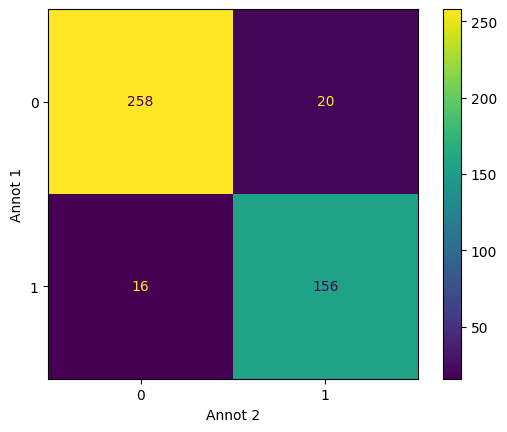

In [28]:
a = confusion_matrix(data_matrix_1[0],data_matrix_1[1])

cm_display = ConfusionMatrixDisplay(confusion_matrix = a, display_labels = [0, 1])

cm_display.plot()
plt.ylabel( "Annot 1") 
plt.xlabel( "Annot 2") 
plt.show()

## Inter-Annotator Agreement - Methodology #2

In [30]:
import json
import numpy as np
from krippendorff import alpha

# Load JSON files
with open('L/luiza_dict_m2.json') as file:
    luiza_annotations = json.load(file)
with open('Z/zuil_dict_m2.json') as file:
    zuil_annotations = json.load(file)

# Assuming both annotators annotated the same items and the items are in the same order
# Extract annotations into a list of lists format for Krippendorff's alpha
items = sorted(luiza_annotations.keys())  # Ensure consistent order of items
data_matrix_2 = [[], []]  # Preparing a 2-row matrix for two annotators

for item in items:
    luiza = luiza_annotations.get(item, None)
    zuil = zuil_annotations.get(item, None)
    
    # Append annotations to the matrix if both annotators have annotated the item
    if luiza is not None and zuil is not None:
        data_matrix_2[0].append(int(luiza))
        data_matrix_2[1].append(int(zuil))

# Convert the lists into a NumPy array for Krippendorff's alpha calculation
data_matrix_2 = np.array(data_matrix_2)

# Calculate and print Krippendorff's alpha
alpha_scalar = alpha(reliability_data=data_matrix_2, level_of_measurement='nominal')
print("Agreement B:", alpha_scalar)


Agreement B: 0.7597476129219285


# Confusion Matrix #2

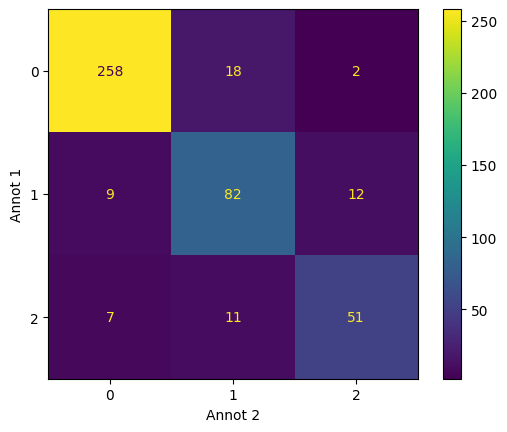

In [31]:
a = confusion_matrix(data_matrix_2[0],data_matrix_2[1])

cm_display = ConfusionMatrixDisplay(confusion_matrix = a, display_labels = [0, 1, 2])

cm_display.plot()
plt.ylabel( "Annot 1") 
plt.xlabel( "Annot 2") 
plt.show()